In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

In [2]:
log_v = "log_downstream_recon"
path = "/home/intern2/fm2026/code_intern/code_it/logs"
run_idx = 29
run_ep = 36
log_root = Path(f"/home/intern2/fm2026/code_intern/code_it/logs/{run_idx:05d}_train/test/ep_{run_ep}")
res_files = sorted(log_root.glob("*.mat"))
print(len(res_files))

112


In [3]:
idx = 0
# idx = 100

25
-0.050139118 3.5955908


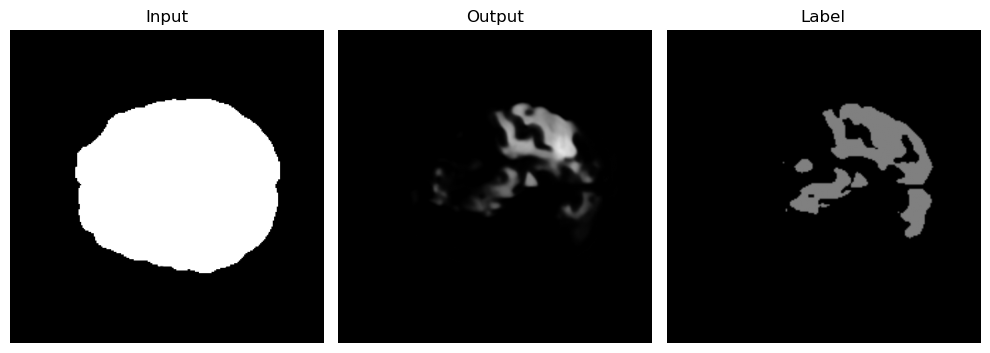

In [28]:
idx += 1
print(idx)

res_mat = loadmat(res_files[idx])
input = res_mat["input"].squeeze()
out = res_mat["out"].squeeze()
label = res_mat["label"].squeeze()

x1, x2, y1, y2 = 20, -20, 20, -20

vmax_out = np.percentile(out, 98) * 1.2
vmax_out = 4.0
vmin = 0

print(out.min(), out.max())

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(input[x1:x2, y1:y2], cmap="gray", vmin=0, vmax=vmax_out)
plt.title("Input")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(out[x1:x2, y1:y2], cmap="gray", vmin=0, vmax=vmax_out)
plt.title("Output")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(label[x1:x2, y1:y2], cmap="gray", vmin=0, vmax=vmax_out)
plt.title("Label")
plt.axis("off")

plt.tight_layout()
plt.show()